<a href="https://colab.research.google.com/github/jiachaol/10718_assigments/blob/main/project/10718_assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 10718 Assignment 1: Getting to know the class project

## Overview

The purpose of this exercise is to provide a quick introduction to the data and modeling problem we'll be using as an illustrative example throughout Machine Learning in Practice (10-718). Note that this colab notebook **only uses a small sample of the data**, but we'll be working with the full dataset as you get into your group projects for the rest of the semester.

**Completing this assignment should only take you 2-3 hours.**

## Problem Background

This notebook makes use of a sample of the data provided by [DonorsChoose](https://www.donorschoose.org/) to the [2014 KDD Cup](https://www.kaggle.com/c/kdd-cup-2014-predicting-excitement-at-donors-choose/data). Public schools in the United States face large disparities in funding, often resulting in teachers and staff members filling these gaps by purchasing classroom supplies out of their own pockets. DonorsChoose is an online crowdfunding platform that tries to help alleviate this financial burden on teachers by allowing them to seek funding for projects and resources from the community (projects can include classroom basics like books and markers, larger items like lab equipment or musical instruments, specific experiences like field trips or guest speakers).

Projects on DonorsChoose expire after 4 months, and if the target funding level isn't reached, the project receives no funding. Since its launch in 2000, the platform has helped fund over 2 million projects at schools across the US, but about 1/3 of the projects that are posted nevertheless fail to meet their goal and go unfunded.

### The Modeling Problem

For the purposes of this exercise, let's assume that DonorsChoose has hired a digital content expert who will review projects and help teachers improve their postings and increase their chances of reaching their funding threshold. Because this individualized review is a labor-intensive process, the digital content expert has ** time to review and support only 10% of the projects posted to the platform on a given day**.

You are a data scientist working with DonorsChoose, and your task is to help this content expert focus their limited resources on projects that most need the help. As such, you want to build a model to **identify projects that are least likely to be fully funded before they expire**  and pass them off to the digital content expert for review.


# Getting Set Up

Running the code below will create a local postgres 11 database for you and import the sampled donors choose data. Don't worry about the details of that and you shouldn't need to touch any of the code here aside from running it. Below, we'll talk about how to access the database from within the notebook to run queries.

In [1]:
# Install and start postgresql-11 server
!sudo apt-get -y -qq update
!wget --quiet -O - https://www.postgresql.org/media/keys/ACCC4CF8.asc | sudo apt-key add -
!echo "deb http://apt.postgresql.org/pub/repos/apt/ `lsb_release -cs`-pgdg main" |sudo tee  /etc/apt/sources.list.d/pgdg.list
!sudo apt-get -y -qq update
!sudo apt-get -y -qq install postgresql-11 postgresql-client-11
!sudo service postgresql start

# Setup a password `postgres` for username `postgres`
!sudo -u postgres psql -U postgres -c "ALTER USER postgres PASSWORD 'postgres';"

# Setup a database with name `donors_choose` to be used
!sudo -u postgres psql -U postgres -c 'DROP DATABASE IF EXISTS donors_choose;'

!sudo -u postgres psql -U postgres -c 'CREATE DATABASE donors_choose;'

# Environment variables for connecting to the database
%env DEMO_DATABASE_NAME=donors_choose
%env DEMO_DATABASE_HOST=localhost
%env DEMO_DATABASE_PORT=5432
%env DEMO_DATABASE_USER=postgres
%env DEMO_DATABASE_PASS=postgres

OK
deb http://apt.postgresql.org/pub/repos/apt/ jammy-pgdg main
W: http://apt.postgresql.org/pub/repos/apt/dists/jammy-pgdg/InRelease: Key is stored in legacy trusted.gpg keyring (/etc/apt/trusted.gpg), see the DEPRECATION section in apt-key(8) for details.
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 12.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package libjson-perl.
(Reading database ... 120893 files and directories currently installed.)
Preparing to unpack .../00-libjson-perl_4.04000-1_all.deb ...
Unpacking libjson-perl (4.04000-1) ...
Selecting previously unselected package netbase.
Preparing to un

In [2]:
# Download sampled DonorsChoose data and load it into our postgres server
!curl -s -OL https://dsapp-public-data-migrated.s3.us-west-2.amazonaws.com/donors_sampled_20210920_v3.dmp
!PGPASSWORD=$DEMO_DATABASE_PASS pg_restore -h $DEMO_DATABASE_HOST -p $DEMO_DATABASE_PORT -d $DEMO_DATABASE_NAME -U $DEMO_DATABASE_USER -O -j 8 donors_sampled_20210920_v3.dmp

In [3]:
!pip install SQLAlchemy==1.3.18 PyYAML==6.0 psycopg2-binary==2.9.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 16.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 682.2/682.2 kB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 30.6 MB/s eta 0:00:00
  Created wheel for SQLAlchemy: filename=SQLAlchemy-1.3.18-cp310-cp310-linux_x86_64.whl size=1236043 sha256=73f6582d93b281aa8f06604e662ee2d480231bc1150e52dc834ac872ce9c5ec8
  Stored in directory: /root/.cache/pip/wheels/c2/ce/f0/920f24badb829d2c35ec186a9646618cb7bbb5cbcfad7441a2
Successfully built SQLAlchemy
  Attempting uninstall: SQLAlchemy
    Found existing installation: SQLAlchemy 2.0.20
    Uninstalling SQLAlchemy-2.0.20:
      Successfully uninstalled SQLAlchemy-2.0.20
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 6.0.1
    Uninstalling PyYAML-6.0.1:
      Successfully uninstalled PyYAML-6.0.1
ERROR: pip's dependency resolver does not currently take into account all the packages 

In [4]:
import pandas as pd
pd.set_option('display.max_columns', None)

In [47]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
from sqlalchemy.engine.url import URL
from sqlalchemy import create_engine

db_url = URL(
            'postgres',
            host='localhost',
            username='postgres',
            database='donors_choose',
            password='postgres',
            port=5432,
        )

db_engine = create_engine(db_url)

# Querying the Database

The code block above used the `sqlalchemy` module to create a connection to the database called `db_engine`. An easy way to run SQL queries against this database is to use the `read_sql` command provided by `pandas`. For instance, if you run the example below, it should return the number of projects in the sampled dataset (16,480):

In [7]:
pd.read_sql("SELECT COUNT(*) FROM data.projects", db_engine)

,count
0,16480


You can find some more details about the dataset on the [KDD Cup page](https://www.kaggle.com/c/kdd-cup-2014-predicting-excitement-at-donors-choose/data), but here is a quick description of the four main source tables:
- `data.projects` contains information about each project that was posted on the site, including IDs for the project, school, and teacher, as well as the total amount being requested (note that projects can also request additional "optional support" but don't need to reach this higher bar to be funded)
- `data.essays` has project titles and descriptions
- `data.resources` has information about the specific resources being requested
- `data.donations` contains details about each donation that was received by a project (when it came in, the amount, whether it was from another teacher, etc.)

** Note that if you prefer to work in python to explore and manipulate the data, you can download a full table (for example, `data.projects`) into a pandas dataframe via**:
```
projects_df = pd.read_sql("SELECT * FROM data.projects", db_engine)
```

## Want other packages?
If you need to install any other python modules for your analysis, you can easily do so from a code block by prefixing your `pip install` command with an `!` character. For instance:
```
!pip install PyYAML
```

# QUESTION 1

**(A)** Create a scatter plot of the number of resources requested vs fraction of the total ask amount that was funded across all projects in New Hampshire. (Hint: You'll need to join a couple of tables here to figure out the amount donated to a project)

In [16]:
project_df = pd.read_sql("SELECT * FROM data.projects", db_engine)
essay_df = pd.read_sql("SELECT * FROM data.essays", db_engine)
donation_df = pd.read_sql("SELECT * FROM data.donations", db_engine)
resource_df = pd.read_sql("SELECT * FROM data.resources", db_engine)

In [11]:
# extract NH projects
project_NH = project_df[project_df['school_state'] == "NH"]
projectid = list(project_NH['projectid_str'].unique())

# extract NH projects info
resource_NH = resource_df[resource_df['projectid_str'].isin(projectid)]
donation_NH = donation_df[donation_df['projectid_str'].isin(projectid)]
resource_NH['resource_num'] = resource_NH['item_unit_price'] * resource_NH['item_quantity']

In [45]:
# calculate total ask amount, total donation, total resource requested
total_ask_amount = list(project_NH['total_price_including_optional_support'])
total_donation = []
total_resource = []

for i in projectid:
  temp_donation = donation_NH[donation_NH['projectid_str'] == i]
  temp_resource = resource_NH[resource_NH['projectid_str'] == i]
  if temp_donation.shape[0] == 0:
    total_donation.append(0)
  else:
    total_donation.append(temp_donation['donation_total'].sum())

  if temp_resource.shape[0] == 0:
    total_resource.append(0)
  else:
    total_resource.append(temp_resource['resource_num'].sum())

In [48]:
total_fraction_funded = list(np.array(total_donation)/np.array(total_ask_amount))

In [50]:
assert(len(total_fraction_funded) == len(total_resource))

Text(0, 0.5, 'fraction of funded price')

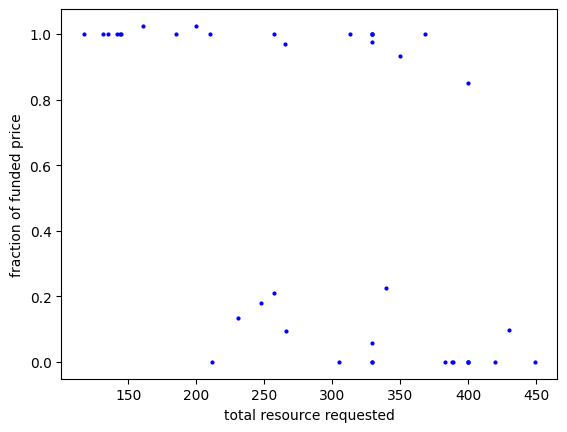

In [168]:
plt.scatter(total_resource, total_fraction_funded, color='blue', marker='o', s = 4)
plt.xlabel("total resource requested")
plt.ylabel("fraction of funded price")

**(B)** Spend a little time exploring the data, with a focus on the outcome of whether or not a project is fully funded after 4 months as well as features you think might be predictive of this outcome.

In [58]:
from tqdm import tqdm

def cal_fund_frac(project_df, resource_df, donation_df):
  project_list = project_df['projectid_str'].unique()
  resource_df['resource_num'] = resource_df['item_unit_price'] * resource_df['item_quantity']

  total_ask_amount = list(project_df['total_price_including_optional_support'])
  total_donation = []
  total_resource = []

  for i in tqdm(project_list):
    temp_donation = donation_df[donation_df['projectid_str'] == i]
    temp_resource = resource_df[resource_df['projectid_str'] == i]
    if temp_donation.shape[0] == 0:
      total_donation.append(0)
    else:
      total_donation.append(temp_donation['donation_total'].sum())

    if temp_resource.shape[0] == 0:
      total_resource.append(0)
    else:
      total_resource.append(temp_resource['resource_num'].sum())
  return total_donation, total_resource, total_ask_amount

In [59]:
total_donation_all, total_resource_all, total_ask_amount_all = cal_fund_frac(project_df, resource_df, donation_df)

In [62]:
print(len(total_resource_all))
print(len(total_donation_all))
print(len(total_ask_amount_all))

16480
16480
16480


In [63]:
total_fund_frac = list(np.array(total_donation_all)/np.array(total_ask_amount_all))

<ipython-input-63-245393d57e15>:1: RuntimeWarning: invalid value encountered in divide
  total_fund_frac = list(np.array(total_donation_all)/np.array(total_ask_amount_all))


In [123]:
# select some features
project_df_sel = project_df[['school_ncesid','school_state','school_charter','school_magnet','school_year_round','school_nlns','school_kipp','school_charter_ready_promise','teacher_prefix','teacher_teach_for_america',\
                            'teacher_ny_teaching_fellow','primary_focus_subject','primary_focus_area','secondary_focus_subject','secondary_focus_area','resource_type','poverty_level','grade_level','fulfillment_labor_materials',\
                            'total_asking_price','total_price_including_optional_support','students_reached','eligible_double_your_impact_match','eligible_almost_home_match']]

In [124]:
project_df_sel

,school_ncesid,school_state,school_charter,school_magnet,school_year_round,school_nlns,school_kipp,school_charter_ready_promise,teacher_prefix,teacher_teach_for_america,teacher_ny_teaching_fellow,primary_focus_subject,primary_focus_area,secondary_focus_subject,secondary_focus_area,resource_type,poverty_level,grade_level,fulfillment_labor_materials,total_asking_price,total_price_including_optional_support,students_reached,eligible_double_your_impact_match,eligible_almost_home_match
0,192013001182,IA,False,False,False,False,False,False,Ms.,False,False,Applied Sciences,Math & Science,College & Career Prep,Applied Learning,Supplies,high poverty,Grades 6-8,35.0,511.32,601.55,100,False,False
1,450111000143,SC,False,False,False,False,False,False,Ms.,False,False,Literacy,Literacy & Language,ESL,Literacy & Language,Supplies,high poverty,Grades 3-5,35.0,167.43,192.45,40,False,False
2,450111000143,SC,False,False,False,False,False,False,Ms.,False,False,Literacy,Literacy & Language,Applied Sciences,Math & Science,Other,high poverty,Grades 3-5,35.0,167.43,196.98,45,False,False
3,450111000143,SC,False,False,False,False,False,False,Mrs.,False,False,Literacy,Literacy & Language,Health & Life Science,Math & Science,Other,high poverty,Grades 3-5,35.0,162.14,190.75,25,False,False
4,450111000143,SC,False,False,False,False,False,False,Mrs.,False,False,History & Geography,History & Civics,Environmental Science,Math & Science,Books,high poverty,Grades 3-5,35.0,381.27,448.55,25,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16475,120039000435,FL,False,False,False,False,False,False,Mrs.,False,False,Literacy,Literacy & Language,None,None,Technology,highest poverty,Grades 3-5,30.0,568.28,668.56,250,True,False
16476,120039000435,FL,False,False,False,False,False,False,Ms.,True,False,Literature & Writing,Literacy & Language,Literacy,Literacy & Language,Books,highest poverty,Grades 3-5,30.0,701.99,825.87,100,True,False
16477,120039000435,FL,False,False,False,False,False,False,Ms.,True,False,Mathematics,Math & Science,Literature & Writing,Literacy & Language,Technology,highest poverty,Grades PreK-2,30.0,1440.59,1694.81,17,False,False
16478,120039000435,FL,False,False,False,False,False,False,Ms.,True,False,Mathematics,Math & Science,None,None,Supplies,highest poverty,Grades 3-5,30.0,608.46,715.84,132,False,False


In [125]:
project_df_sel['y'] = total_fund_frac
project_df_sel = project_df_sel.dropna(axis=0)
project_df_sel_nan = project_df_sel[project_df_sel.isna().any(axis=1)]

<ipython-input-125-20a7d84e493b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  project_df_sel['y'] = total_fund_frac


In [126]:
project_df_sel

,school_ncesid,school_state,school_charter,school_magnet,school_year_round,school_nlns,school_kipp,school_charter_ready_promise,teacher_prefix,teacher_teach_for_america,teacher_ny_teaching_fellow,primary_focus_subject,primary_focus_area,secondary_focus_subject,secondary_focus_area,resource_type,poverty_level,grade_level,fulfillment_labor_materials,total_asking_price,total_price_including_optional_support,students_reached,eligible_double_your_impact_match,eligible_almost_home_match,y
0,192013001182,IA,False,False,False,False,False,False,Ms.,False,False,Applied Sciences,Math & Science,College & Career Prep,Applied Learning,Supplies,high poverty,Grades 6-8,35.0,511.32,601.55,100,False,False,1.000000
1,450111000143,SC,False,False,False,False,False,False,Ms.,False,False,Literacy,Literacy & Language,ESL,Literacy & Language,Supplies,high poverty,Grades 3-5,35.0,167.43,192.45,40,False,False,1.000000
2,450111000143,SC,False,False,False,False,False,False,Ms.,False,False,Literacy,Literacy & Language,Applied Sciences,Math & Science,Other,high poverty,Grades 3-5,35.0,167.43,196.98,45,False,False,0.849985
3,450111000143,SC,False,False,False,False,False,False,Mrs.,False,False,Literacy,Literacy & Language,Health & Life Science,Math & Science,Other,high poverty,Grades 3-5,35.0,162.14,190.75,25,False,False,0.850013
4,450111000143,SC,False,False,False,False,False,False,Mrs.,False,False,History & Geography,History & Civics,Environmental Science,Math & Science,Books,high poverty,Grades 3-5,35.0,381.27,448.55,25,False,False,0.044588
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16470,120039000435,FL,False,False,False,False,False,False,Mr.,True,False,Mathematics,Math & Science,Applied Sciences,Math & Science,Technology,highest poverty,Grades 3-5,30.0,1181.98,1390.56,80,False,False,1.000000
16471,120039000435,FL,False,False,False,False,False,False,Ms.,True,False,Health & Life Science,Math & Science,Literacy,Literacy & Language,Technology,highest poverty,Grades PreK-2,30.0,853.96,1004.66,17,True,False,0.000000
16476,120039000435,FL,False,False,False,False,False,False,Ms.,True,False,Literature & Writing,Literacy & Language,Literacy,Literacy & Language,Books,highest poverty,Grades 3-5,30.0,701.99,825.87,100,True,False,0.012108
16477,120039000435,FL,False,False,False,False,False,False,Ms.,True,False,Mathematics,Math & Science,Literature & Writing,Literacy & Language,Technology,highest poverty,Grades PreK-2,30.0,1440.59,1694.81,17,False,False,0.005900


In [127]:
from sklearn.preprocessing import LabelEncoder
def label_encoder(feature, df):
  label_encoder = LabelEncoder()
  df_new = label_encoder.fit_transform(df[feature])
  return df_new

In [128]:
project_df_sel_encoded = pd.DataFrame()
col_list = list(project_df_sel.columns)
for i in col_list:
  if (project_df_sel[i].dtype != 'float64') and (project_df_sel[i].dtype != 'int64'):
    project_df_sel_encoded[i] = label_encoder(i,project_df_sel)
  else:
    project_df_sel_encoded[i] = project_df_sel[i]

In [135]:
project_df_sel_encoded_cleaned = project_df_sel_encoded.dropna(axis=0)
print(project_df_sel_encoded_cleaned.shape)

(6772, 25)


In [136]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [138]:
X_train, X_test, y_train, y_test = train_test_split(project_df_sel_encoded_cleaned.drop(project_df_sel_encoded_cleaned.columns[-1], axis=1), project_df_sel_encoded_cleaned['y'], test_size=0.2, random_state=42)

In [140]:
model = RandomForestRegressor(n_estimators=100)  # You can adjust hyperparameters as needed
model.fit(X_train, y_train)

RandomForestRegressor()

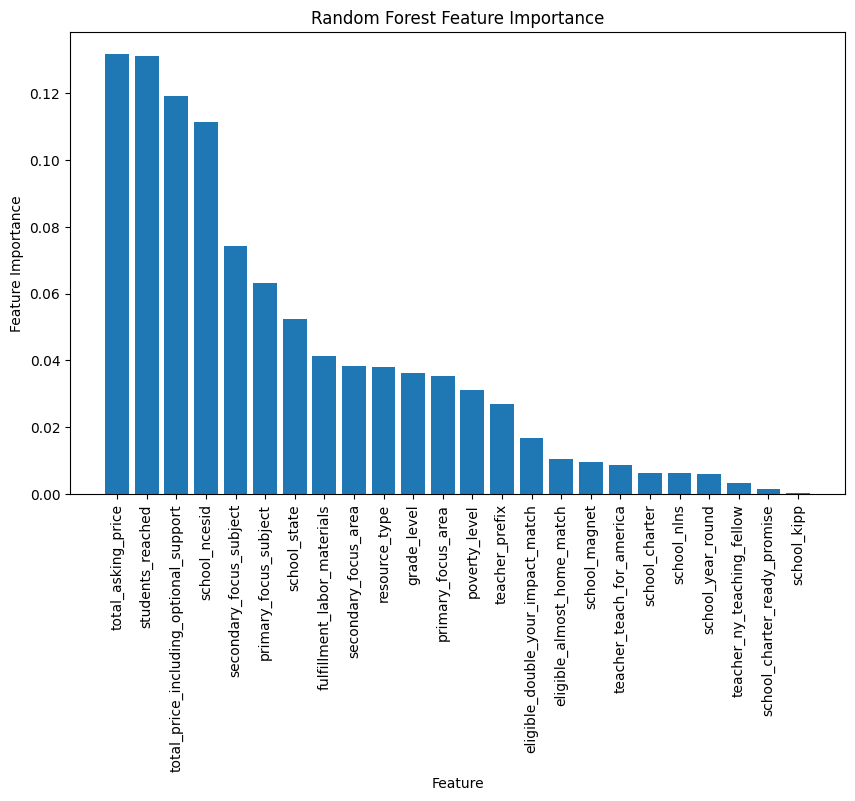

In [141]:
feature_importance = model.feature_importances_
sorted_idx = feature_importance.argsort()[::-1]

feature_names = project_df_sel_encoded_cleaned.columns[0:24]  # Replace with your actual feature names or labels

# Feature Importance visualization
plt.figure(figsize=(10, 6))
plt.bar(range(24), feature_importance[sorted_idx], align="center")
plt.xticks(range(24), feature_names[sorted_idx], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Feature Importance")
plt.title("Random Forest Feature Importance")
plt.show()

It looks like the most important features are related to the prices requested, student number benefiting from the project, focus subject,  cost of fulfillment, grade level, poverty level, etc.

# QUESTION 2

For this question, you'll develop a model to help DonorsChoose **identify 10% of projects with the highest risk of failing to meet their funding goal** for their digital content expert review and provide suggestions. In order to intervene early in the process, DonorsChoose wants to identify these projects to help **immediately upon being posted** to the site.

Build and evaluate the performance of several machine learning models for this task. **Be sure to use comments or text blocks to discuss the choices and assumptions you're making along the way.** Feel free to use any python packages available (such as sklearn) for this.

In [143]:
# split train and test datasets
X = project_df_sel_encoded_cleaned.drop(project_df_sel_encoded_cleaned.columns[-1], axis=1)
y = project_df_sel_encoded_cleaned['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [145]:
# linear regression model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# assume linear relationship between the features and fraction of total price that is funded.
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

# Predict the values using the test set
y_pred = lin_reg.predict(X_test)

# Calculate the Mean Squared Error
print("LR model Mean Squared Error:", mean_squared_error(y_test, y_pred))

Mean Squared Error: 0.19819715951729217


In [155]:
# transforming y to be binary
y_train_bin = [1 if x >= 1 else 0 for x in y_train]
y_test_bin = [1 if x >= 1 else 0 for x in y_test]

In [158]:
# logistic regression model
from sklearn.linear_model import LogisticRegression

# assumes linearity of independent variables and log odds
log_reg = LogisticRegression(solver="lbfgs",max_iter=10000)
log_reg.fit(X_train, y_train_bin)

# Predict the classes using the test set
y_pred = log_reg.predict(X_test)

# Calculate the accuracy
print("LogR model Mean Squared Error:", mean_squared_error(y_test_bin, y_pred))

LogR model Mean Squared Error: 0.3151291512915129


In [167]:
# random forest model
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=200, max_depth = 10, min_samples_leaf = 2, min_samples_split = 5, random_state=42)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

# Calculate the Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f"RF Mean Squared Error: {mse:.2f}")

RF Mean Squared Error: 0.19


# QUESTION 3

Briefly discuss (in at most 1-2 paragraphs) the results of your analysis above: Which model would you select to deploy and why? Are there future analysis or improvements you would suggest? Are there other data sources you would ideally like to be able to incorporate into your models?

I tried three simple ML models: (1) linear regression, (2) logistic regrssion and (3) random forest regression. The best model is random forest regression model since its MSE is smallest (0.19), I would recommend deploying this model. The future analysis and improvements can be several directions: (1) feature engineering: we should perform more feature selection techniques to extract most useful features to build model. Also we should try scale some features and perform some cleaning befreo feeding the data to models. (2) Hyper-parameter choices for complicated model: when using more complicated models (such as RF), we should test different hyper-parameter combinations to choose the best one with best performance since these parameters affect the model performance a lot.

I think we can incorporate some more data related to students such as family background, racial diversity and some metrics related potential benefits to school or even local community after funding the projects. If I was looking for funding a school project, I would pay much attention to the educational and social impact of this project.

# Submission

To submit your exercise, please **save a copy** of this notebook containing your code and outputs (you can save it either to google drive or github, but make sure the course staff will have read permissions to access it).

Provide a link to your copy of the notebook when you submit the assignment in canvas.

Thank you and we're looking forward to a great semester in 10718!